In [23]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style="ticks", color_codes=True)
%matplotlib inline
# %matplotlib notebook

# Introduction

The aim of this notebook is to use a shorter temporal aggregation than that used in NB01, and to only look at the time before the peaks in cyanobacteria and chl-a when calculating summary statistics for the potential explanatory variables. The hope is to tease out more causative relationships, rather than just correlative ones.

Notebooks steps:

1) Generate data matrices including potential features of use in predicting lake chemistry and ecology in Lake Vansjø. Data is read in for the River Hobøl and Lake Vansjø in the Morsa vannområde. Data includes meteorological data, NVE discharge data, river chemistry data and lake chemistry and ecology data for the period ca. 1980-2018.

2) In contrast to NB01, in this notebook a shorter temporal aggregation is used: First, pick out the target variable per year. This is the month where the average is highest for that year. Explanatory variables are then averages or sums for the previous n days (e.g. 14 - 90 days).

3) Carry out exploratory data analysis to help identify potentially important relationships. This includes exploration of correlation coefficients and some graphs. Data matrices for chl-a concentration and biovolume of cyanobacteria are written to csv for use elsewhere.

This notebook builds on notebook A_Make_data_matrix.ipynb, where the aim was monthly rather than seasonal aggregation of the data. Notebook A contains some more exploration of the daily data and explanations for some of the data cleaning choices made.

Created by Leah JB. Part of the ERA4CS WATExR project.

# User input

In [24]:
# File path to daily data
infpath = r'../Data/DataMatrices/Daily/Vansjø_daily_data_Van2_metno.csv'

# Folder to store output csv and plots
out_folder_data = r'../Data/DataMatrices/prepeak_aggregation/'
out_folder_stats = r'../Data/CorrelationCoeffs/prepeak_aggregation'

# How many days to consider before the peak in algal variable for
# aggregating the explanatory variables (i.e. calculating mean or sum)?
# Have run notebook for 14, 30, 60, 90 days
days_before_peak = 90

met_source = 'metno'  # 'metno' is the only option here

# Read in daily data

In [25]:
# READ IN
daily_df = pd.read_csv(infpath, index_col=0, parse_dates=True, dayfirst=True)
daily_df.head()

,Pptn,Temp,Wind_speed,Q,TP_catch,chl-a_lake,TP_lake,colour_lake,CyanoBiovol,Rain_day,Pptn_intense,Wind_under_Q0.2,Wind_under_Q0.4,Wind_over_Q0.6,Wind_over_Q0.8,Temp_subzero
Date,,,,,,,,,,,,,,,,
1980-01-01,0.000000,-4.758278,2.9,4.252,NaN,NaN,NaN,NaN,NaN,0,0,False,False,False,False,True
1980-01-02,0.000000,-8.821736,3.1,5.544,NaN,NaN,NaN,NaN,NaN,0,0,False,False,False,False,True
1980-01-03,0.000000,-15.280719,1.5,8.203,NaN,NaN,NaN,NaN,NaN,0,0,True,True,False,False,True
1980-01-04,2.669136,-12.965066,1.7,10.461,NaN,NaN,NaN,NaN,NaN,1,0,True,True,False,False,True
1980-01-05,2.806878,-5.304253,1.5,10.239,NaN,NaN,NaN,NaN,NaN,1,0,True,True,False,False,True


# Resample

In this notebook, we:
1) pick out the peak chl-a or cyanobacteria value per year. This single maximum value is the value used for chl-a and cyano throughout the rest of the notebook.
2) using the date of this peak, count back 30, 60 or 90 days and calculate means or sums of the potential explanatory variable over this "pre-peak" time window.

Results of these two analyses are stored in "yr_df", and then the same correlation coefficients and scatterplot matrices are calculated as in the 6 month aggregation.

In [26]:
# Set the aggregation method for different variables
vars_to_sum = ["Pptn", "Rain_day", "Pptn_intense", "PET", "Q", "Temp_subzero"]

# Add wind cols to vars to sum
wind_cols = []
calm_quantiles = [0.2, 0.4]
windy_quantiles = [0.6, 0.8]
for q in calm_quantiles:
    wind_cols.append("Wind_under_Q%s" % q)
for q in windy_quantiles:
    wind_cols.append("Wind_over_Q%s" % q)
vars_to_sum += wind_cols

vars_to_average = [
    "TP_catch",
    "PTI",
    "Temp",
    "Biovolume",
    "rel_res_time",
    "colour_lake",
    "TP_lake",
    "Wind_speed",
]

vars_to_max = ["CyanoBiovol", "chl-a_lake"]

agg_method_dict = {}  # Key: var, returns aggregation method
for var in daily_df.columns:
    if var in vars_to_sum:
        method = np.sum
    elif var in vars_to_average:
        method = np.nanmean
    elif var in vars_to_max:
        method = np.nanmax
    else:
        method = None
    agg_method_dict[var] = method

In [27]:
yr_df_dict = {}  # keys: "cyano", "chla". Returns yr_df

var_dict = {"cyano": "CyanoBiovol", "chla": "chl-a_lake"}  # for naming

for var in ["cyano", "chla"]:
    long_var = var_dict[var]

    # Find annual peak of cyano or chla and add to new yr_df (annually aggregated values)
    yr_df = (daily_df[long_var].resample("Y", closed="left").agg(np.nanmax)).to_frame()

    # Remove frequncy info from index so all plotting works right & reindex to just year
    yr_df.index.freq = None
    yr_df.index = yr_df.index.year

    yr_df = pd.concat([yr_df, pd.DataFrame(columns=["peak_date", "peak_day"])])

    # Find date when annual maximum occurred
    for year_group in daily_df.groupby(daily_df.index.year):
        year = year_group[0]
        peak_date = year_group[1][long_var].idxmax()
        yr_df.loc[year, "peak_date"] = peak_date

    yr_df["peak_date"] = pd.to_datetime(yr_df["peak_date"])
    yr_df["peak_day"] = yr_df["peak_date"].dt.dayofyear

    # Set up for calculating pre-peak summaries for other variables
    extra_cols = daily_df.drop(long_var, axis=1).columns
    yr_df = pd.concat([yr_df, pd.DataFrame(columns=extra_cols)])

    groups = daily_df.copy().groupby(daily_df.index.year)
    for group in groups:
        yr = group[0]
        peak_date = yr_df.loc[yr, "peak_date"]
        daily_data = group[1].loc[
            peak_date - pd.Timedelta(days_before_peak, unit="D"): peak_date
        ]
        aggregated = daily_data.agg(agg_method_dict)
        aggregated.name = yr
        yr_df.loc[yr, aggregated.index] = aggregated.values

    yr_df = yr_df.loc[1980:2018, :]  # Drop 2019 as not complete

    # Summing over seasons gives 0 for Q due to no data. Replace with NaNs
    for sum_var in ["Q", "Pptn"]:
        yr_df.loc[yr_df[sum_var] == 0.0, sum_var] = np.NaN

    yr_df_dict[var] = yr_df

    # Output to csv
    yr_df.to_csv(
        os.path.join(
            out_folder_data,
            "%s_peak_%sdays_prepeak_summary_for_explanatoryvars_%s.csv"
            % (var, days_before_peak, met_source),
        )
    )

print("chla:")
print(yr_df_dict["chla"].tail())
print("cyano:")
print(yr_df_dict["cyano"].tail())

chla:
      chl-a_lake  peak_date  peak_day        Pptn       Temp Wind_speed  \
2014        17.0 2014-06-10     161.0  163.398196   9.578178   3.548352   
2015        34.0 2015-08-19     231.0  283.790271  14.839259   3.952747   
2016        16.0 2016-08-15     228.0  279.090196  16.208895   3.812088   
2017        21.0 2017-07-31     212.0  184.272861  14.849319   3.773626   
2018        16.0 2018-10-08     281.0  195.961011  15.870764   4.084615   

            Q   TP_catch    TP_lake colour_lake CyanoBiovol Rain_day  \
2014  268.432  56.076923      20.25      58.825       0.113     25.0   
2015  274.413     51.875  22.714286        47.0       0.233     35.0   
2016   78.538       58.0  18.928571        52.0       0.163     37.0   
2017  221.748  32.285714  19.142857   43.333333       0.232     36.0   
2018   25.526        NaN       19.0        30.0       0.614     29.0   

     Pptn_intense Wind_under_Q0.2 Wind_under_Q0.4 Wind_over_Q0.6  \
2014          5.0             8.0         

# Quick plots to visualize the data

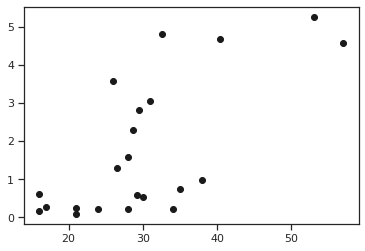

In [28]:
x = yr_df_dict['chla']['chl-a_lake']
y = yr_df_dict['cyano']['CyanoBiovol']
plt.plot(x, y, 'ko')

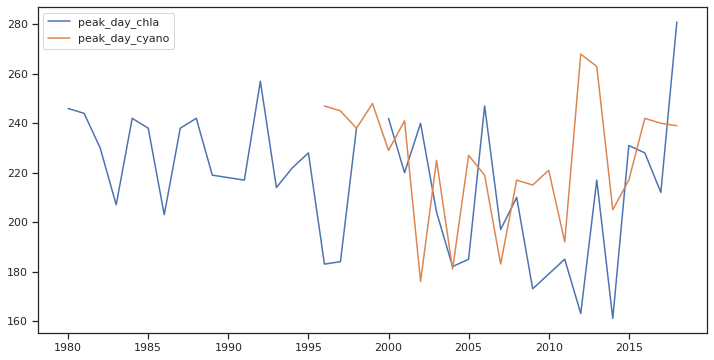

In [29]:
peak_day_df = pd.concat(
    [yr_df_dict["chla"]["peak_day"], yr_df_dict["cyano"]["peak_day"]], axis=1
)
peak_day_df.columns = ["peak_day_chla", "peak_day_cyano"]
peak_day_df[["peak_day_chla", "peak_day_cyano"]].plot(figsize=(12, 6))
plt.show()

# Correlations

Quick look at simple correlations as a first indication of relationships between variables.

In [30]:
sorted(yr_df.columns)

['CyanoBiovol',
 'Pptn',
 'Pptn_intense',
 'Q',
 'Rain_day',
 'TP_catch',
 'TP_lake',
 'Temp',
 'Temp_subzero',
 'Wind_over_Q0.6',
 'Wind_over_Q0.8',
 'Wind_speed',
 'Wind_under_Q0.2',
 'Wind_under_Q0.4',
 'chl-a_lake',
 'colour_lake',
 'peak_date',
 'peak_day']

In [31]:
def correlation_stats(df, var, cols_to_drop, days_before_peak,
                      plot_scattermatrix=False):
    """
    Take a df with year index and columns for each variable, and
    pick out the response variable (var), drop columns which are
    not to be considered as explanatory variables (cols_to_drop).
    Then drop NaNs and calculate Pearson's correlation coefficients
    between var and each of the remaining columns. Sort the results
    by value and save to csv. The input days_before_peak is just
    used in file naming, so this function can be easily repeated for
    a variety of days_before_peak.

    If plot_scattermatrix is True, then a scattermatrix is
    plot.

    Returns df of correlation coefficients.
    """

    long_var = var_dict[var]

    cur_df = yr_df_dict[var].drop(cols_to_drop, axis=1).astype(float)
    print("data rows in raw df: %s" % len(cur_df))

    # Drop any rows where target var is a NaN
    cur_df.dropna(subset=[long_var], inplace=True)
    print("data rows after dropping NaNs in target variable: %s" % len(cur_df))

    X = cur_df.drop([long_var], axis=1)
    y = cur_df[long_var]
    corr_df = X.corrwith(y, method="pearson")
    out_fpath = os.path.join(out_folder_stats,
                             "Van2_corrcoeffs_%s_%sdays_prepeak_%smetdata.csv" % (var, days_before_peak, met_source))
    corr_df.sort_values().to_csv(out_fpath)
    print(
        "correlation coefficients, aggregation over %s days before %s peak:"
        % (days_before_peak, var)
    )

    mapping = {
        "CyanoBiovol": "Cyano",
        "PET": "PET",
        "Pptn": "P",
        "Pptn_intense": "High P",
        "Q": "Q",
        "Rain_day": "P count",
        "TP_catch": "TP catch",
        "TP_lake": "TP",
        "Temp": "T",
        "Temp_subzero": "T>0",
        "Wind_over_Q0.6": "w_Q6",
        "Wind_over_Q0.8": "w_Q8",
        "Wind_speed": "w",
        "Wind_under_Q0.2": "w_Q2",
        "Wind_under_Q0.4": "w_Q4",
        "chl-a_lake": "chla",
        "colour_lake": "color",
        "peak_date": "peak_date",
        "peak_day": "peak_day",
    }
    cur_df = cur_df.rename(columns=mapping)

    corr_df.name = days_before_peak
    corr_df.sort_values().to_csv(
        os.path.join(
            out_folder_stats,
            "corr_coeffs_%s_%sdaysPrePeak_%s.csv" % (var, days_before_peak, met_source)
        )
    )

    if plot_scattermatrix is True:
        pd.plotting.scatter_matrix(cur_df, figsize=(14, 14));

    return corr_df.sort_values()

In [32]:
var = "chla"

cols_to_drop = [
    "CyanoBiovol",
    "Temp_subzero",
    "TP_catch",
    "peak_date",
    "peak_day",
]
corr_df = correlation_stats(
    yr_df_dict[var], var, cols_to_drop, days_before_peak, plot_scattermatrix=False
)
corr_df

data rows in raw df: 39
data rows after dropping NaNs in target variable: 38
correlation coefficients, aggregation over 90 days before chla peak:


Wind_over_Q0.8    -0.321150
Wind_speed        -0.231568
Wind_over_Q0.6    -0.152888
Q                 -0.099798
Rain_day          -0.079761
Pptn              -0.010484
Temp               0.033258
colour_lake        0.104117
Pptn_intense       0.114411
Wind_under_Q0.4    0.116547
Wind_under_Q0.2    0.127937
TP_lake            0.358825
Name: 90, dtype: float64

**Comments on chl-a results**

30 days prior to peak:
- All ccs less than 0.25 (absolute)
- Strongest are with wind speed, wind under/over 0.2/0.8 (windier -> lower chl-a) and TP lake (0.21)

60 days prior to peak:
- Similar story, but CCs a little bit higher
- TP_lake now highest CC (0.34), followed by wind>Q8 (-0.31), wind speed (-0.25)

90 days prior to peak:
- Similar to 60 days (TP_lake is 0.36, Q0.8 wind -0.32, wind speed -0.23). All others v. low
- Calm days drops down to v. low

Summary of strongest correlations:
- lake_TP: 0.21 (30 days) to 0.36 (90 days)
- wind: wind speed (14 days: -0.35, 30 days: -0.24), >Q0.8 (14:-0.32, 60, 90 days; CCs -0.31, -0.32)

**Comparison to 6 month aggregation:**
Similar results.
CC with lake_TP is now weaker (was 0.58, now down to 0.2-0.4), but still one of strongest correlations. Wind variables are still the only met variables that appear to be important, and they're as important as lake TP concentration. Nothing else comes out (e.g. temperature).

In [33]:
var = "cyano"

cols_to_drop = [
    "Temp_subzero",
    "TP_catch",
    "peak_date",
    "peak_day",
]
corr_df = correlation_stats(yr_df_dict[var], var, cols_to_drop, days_before_peak)
corr_df

data rows in raw df: 39
data rows after dropping NaNs in target variable: 23
correlation coefficients, aggregation over 90 days before cyano peak:


colour_lake       -0.407909
Temp              -0.144709
Rain_day          -0.121594
Pptn              -0.107906
Q                 -0.096899
Wind_over_Q0.6    -0.000048
Wind_under_Q0.4    0.005679
Wind_over_Q0.8     0.043560
Wind_speed         0.045383
Pptn_intense       0.050266
Wind_under_Q0.2    0.125932
TP_lake            0.508460
chl-a_lake         0.549212
Name: 90, dtype: float64

**Comments on cyanomax results**

Strongest correlations are with:
- TP_lake. The correlation coefficients decrease as the pre-peak window increases, from 0.71 (n=14) to 0.51 (n=90)
- chl-a_lake. Fairly constant CC wrt window size. Around 0.48 (n=14) to 0.55 (n=90)
- lake colour. Variable, in range -0.33 (14) to -0.45 (60)
- Delivery/hydrology: strong'ish correlations with Q, rain days and precipitation amount for windows LESS THAN 90. Variable according to aggregation window. E.g. Q is around -0.32 for 14 and 30 days, then small. Rain days is -0.41,-0.45 for 30 and 60 days, otherwise small. Precipitation amount is -0.36, -0.39 for 30 and 60 days. Some consistent indication that the larger the inflow/rain the lower the cyanobacterial biomass.
- Not much with wind, nothing with temperature

**Comparison to 6-monthly results:** similar correlations with TP_lake, chl-a_lake and lake_colour. Similar lack of correlation with temperature and wind. BUT, some indication that freshwater delivery matters (residence time/turnover).